#  소프트맥스 회귀로 MNIST 데이터 분류하기

* 총 60,000개의 훈련 데이터와 레이블, 총 10,000개의 테스트 데이터와 레이블로 구성
* 레이블은 0부터 9까지 총 10개
* 28 픽셀 × 28 픽셀 = 784 픽셀이므로, 각 이미지를 총 784의 원소를 가진 벡터


In [1]:
'''
for X, Y in data_loader:
    # 입력 이미지를 [batch_size × 784]의 크기로 reshape
    # 레이블은 원-핫 인코딩
  X = X.view(-1, 28*28)
'''

'\nfor X, Y in data_loader:\n    # 입력 이미지를 [batch_size × 784]의 크기로 reshape\n    # 레이블은 원-핫 인코딩\n  X = X.view(-1, 28*28)\n'

## 2. 토치비전(torchvision) 소개하기
* torchvision은 유명한 데이터셋들, 이미 구현되어져 있는 유명한 모델들, 일반적인 이미지 전처리 도구들을 포함하고 있는 패키지가 있다
* 자연어 처리를 위해서는 토치텍스트(torchtext)라는 패키지가 있다

## 3. 분류기 구현을 위한 사전 설정

In [2]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)


# 랜덤 시드 고정
# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)


# hyperparameters
training_epochs = 15
batch_size = 100

다음 기기로 학습합니다: cuda


## 4. MNIST 분류기 구현하기

In [3]:
# MNIST dataset
# torchvision.datasets.dsets.MNIST
mnist_train = dsets.MNIST(root='A:/chchdata/data/MNIST_data/', #MNIST 데이터를 다운로드 받을 경로
                          train=True, # 훈련 데이터를 받음, False면 테스트 데이터를 받음
                          transform=transforms.ToTensor(),# 파이토치 텐서로 변환
                          download=True) #해당 경로에 MNIST 데이터가 없다면 다운로드 받겠다는 의미

mnist_test = dsets.MNIST(root='A:/chchdata/data/MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

C:\Users\sswwd\anaconda3\envs\chch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# dataset loader
data_loader = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size, # 배치 크기는 100
                                          shuffle=True,
                                          drop_last=True) #drop_last는 마지막 배치를 버릴 것인지를 의미

drop_last를 하는 이유를 이해하기 위해서 1,000개의 데이터가 있다고 했을 때, 배치 크기가 128이라고 해봅시다. 1,000을 128로 나누면 총 7개가 나오고 나머지로 104개가 남습니다. 이때 104개를 마지막 배치로 한다고 하였을 때 128개를 충족하지 못하였으므로 104개를 그냥 버릴 수도 있습니다. 이때 마지막 배치를 버리려면 drop_last=True를 해주면 됩니다. 이는 **다른 미니 배치보다 개수가 적은 마지막 배치를 경사 하강법에 사용하여 마지막 배치가 상대적으로 과대 평가되는 현상을 막아줍니다.**

In [5]:
# MNIST data image of shape 28 * 28 = 784 / output_dim은 10
linear = nn.Linear(784, 10, bias=True).to(device) # bias 기본값은 True

In [6]:
# 비용 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

for epoch in range(training_epochs): # 앞서 training_epochs의 값은 15로 지정함.
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        # 배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 된다.
        X = X.view(-1, 28 * 28).to(device) # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수.
        # print('X : ', X)        
        # print(X.size())
        
        Y = Y.to(device)
        # print('Y : ', Y)
        # print(Y.size())

        optimizer.zero_grad()
        hypothesis = linear(X)
        # print('hypothesis :' , hypothesis)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

'''
X :  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
torch.Size([100, 784])
Y :  tensor([8, 6, 7, 7, 0, 1, 9, 7, 1, 9, 7, 6, 1, 1, 8, 0, 3, 3, 5, 4, 9, 6, 9, 7,
        3, 5, 0, 7, 7, 0, 9, 0, 9, 5, 2, 0, 3, 5, 4, 4, 8, 1, 1, 9, 7, 2, 2, 6,
        0, 9, 6, 5, 7, 9, 9, 4, 4, 3, 9, 1, 3, 4, 3, 3, 8, 9, 4, 9, 6, 2, 0, 4,
        5, 8, 5, 5, 3, 9, 2, 7, 6, 0, 3, 8, 1, 1, 6, 3, 3, 1, 4, 5, 9, 4, 7, 1,
        0, 4, 3, 7], device='cuda:0')
torch.Size([100])
'''

Epoch: 0001 cost = 0.535146713
Epoch: 0002 cost = 0.359576792
Epoch: 0003 cost = 0.331263006
Epoch: 0004 cost = 0.316403985
Epoch: 0005 cost = 0.307106525
Epoch: 0006 cost = 0.300456434
Epoch: 0007 cost = 0.294932842
Epoch: 0008 cost = 0.290955842
Epoch: 0009 cost = 0.287074119
Epoch: 0010 cost = 0.284515619
Epoch: 0011 cost = 0.281915396
Epoch: 0012 cost = 0.279526889
Epoch: 0013 cost = 0.277636290
Epoch: 0014 cost = 0.275875181
Epoch: 0015 cost = 0.274422675
Learning finished


"\nX :  tensor([[0., 0., 0.,  ..., 0., 0., 0.],\n        [0., 0., 0.,  ..., 0., 0., 0.],\n        [0., 0., 0.,  ..., 0., 0., 0.],\n        ...,\n        [0., 0., 0.,  ..., 0., 0., 0.],\n        [0., 0., 0.,  ..., 0., 0., 0.],\n        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')\ntorch.Size([100, 784])\nY :  tensor([8, 6, 7, 7, 0, 1, 9, 7, 1, 9, 7, 6, 1, 1, 8, 0, 3, 3, 5, 4, 9, 6, 9, 7,\n        3, 5, 0, 7, 7, 0, 9, 0, 9, 5, 2, 0, 3, 5, 4, 4, 8, 1, 1, 9, 7, 2, 2, 6,\n        0, 9, 6, 5, 7, 9, 9, 4, 4, 3, 9, 1, 3, 4, 3, 3, 8, 9, 4, 9, 6, 2, 0, 4,\n        5, 8, 5, 5, 3, 9, 2, 7, 6, 0, 3, 8, 1, 1, 6, 3, 3, 1, 4, 5, 9, 4, 7, 1,\n        0, 4, 3, 7], device='cuda:0')\ntorch.Size([100])\n"

Accuracy: 0.8883000016212463
Label:  8
Prediction:  3


C:\Users\sswwd\anaconda3\envs\chch\lib\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\sswwd\anaconda3\envs\chch\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


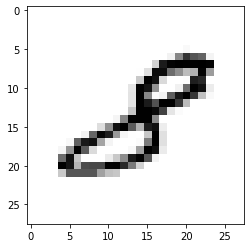

In [7]:
# 테스트 데이터를 사용하여 모델을 테스트한다.
with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()
    